In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')
import os
os.getcwd()

Using TensorFlow backend.
/home/manoj/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/manoj/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/manoj/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/manoj/anaconda3/lib/python3.7/site-packages/tensorflo

'/home/manoj/Documents/cnn_project'

In [2]:
print(os.listdir("/home/manoj/Documents/cnn_project"))

['train', 'test', '.ipynb_checkpoints', 'Dog_and_Cat_Classification_cnn.ipynb']


In [3]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [4]:
filenames = os.listdir("/home/manoj/Documents/cnn_project/train")
categories=[]
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
        'filename' : filenames,
        'category' : categories
})

In [5]:
df.head()

,filename,category
0,dog.2132.jpg,1
1,dog.2311.jpg,1
2,cat.3042.jpg,0
3,dog.204.jpg,1
4,dog.5671.jpg,1


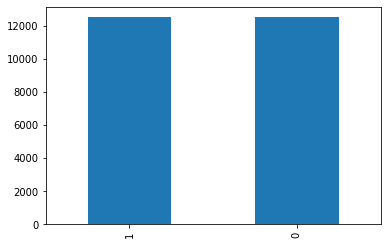

In [6]:
df['category'].value_counts().plot.bar()

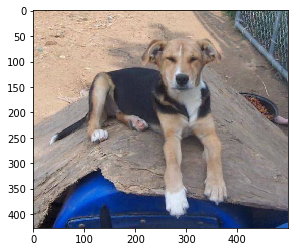

In [7]:
sample = random.choice(filenames)
image = load_img("/home/manoj/Documents/cnn_project/train/"+sample)
plt.imshow(image)

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

In [9]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)       

In [11]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=5)

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                           patience=2,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.00001)

In [13]:
callbacks = [earlystop, learning_rate_reduction]

In [14]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

In [15]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)

In [16]:
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

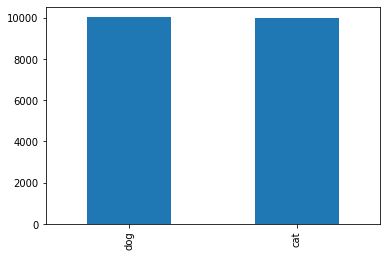

In [17]:
train_df.category.value_counts().plot.bar()

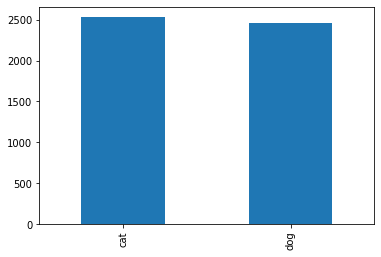

In [18]:
validate_df.category.value_counts().plot.bar()

In [19]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 15

In [20]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "/home/manoj/Documents/cnn_project/train/",
    x_col ='filename',
    y_col= 'category',
    target_size=IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size=batch_size)

Found 20000 validated image filenames belonging to 2 classes.


In [21]:
validation_datagen = ImageDataGenerator(
    rotation_range=18,
    rescale=1./255,
    zoom_range=0.3,
    )
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "/home/manoj/Documents/cnn_project/train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size)

Found 5000 validated image filenames belonging to 2 classes.


In [22]:
epochs=3 if FAST_RUN else 10
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
1333/1333 [==============================] - 6692s 5s/step - loss: 0.7547 - accuracy: 0.6106 - val_loss: 0.7025 - val_accuracy: 0.6478
Epoch 2/10
1333/1333 [==============================] - 6092s 5s/step - loss: 0.6166 - accuracy: 0.6696 - val_loss: 0.7141 - val_accuracy: 0.7332
Epoch 3/10
1333/1333 [==============================] - 22591s 17s/step - loss: 0.5651 - accuracy: 0.7151 - val_loss: 0.5701 - val_accuracy: 0.7270
Epoch 4/10
1333/1333 [==============================] - 17916s 13s/step - loss: 0.5427 - accuracy: 0.7322 - val_loss: 0.4692 - val_accuracy: 0.6955
Epoch 5/10
1333/1333 [==============================] - 2923s 2s/step - loss: 0.5367 - accuracy: 0.7304 - val_loss: 0.9939 - val_accuracy: 0.7001
Epoch 6/10
1333/1333 [==============================] - 8146s 6s/step - loss: 0.5309 - accuracy: 0.7381 - val_loss: 0.7033 - val_accuracy: 0.7184
Epoch 7/10
1333/1333 [==============================] - 8247s 6s/step - 

In [23]:
model.save_weights("model.h5")

No handles with labels found to put in legend.


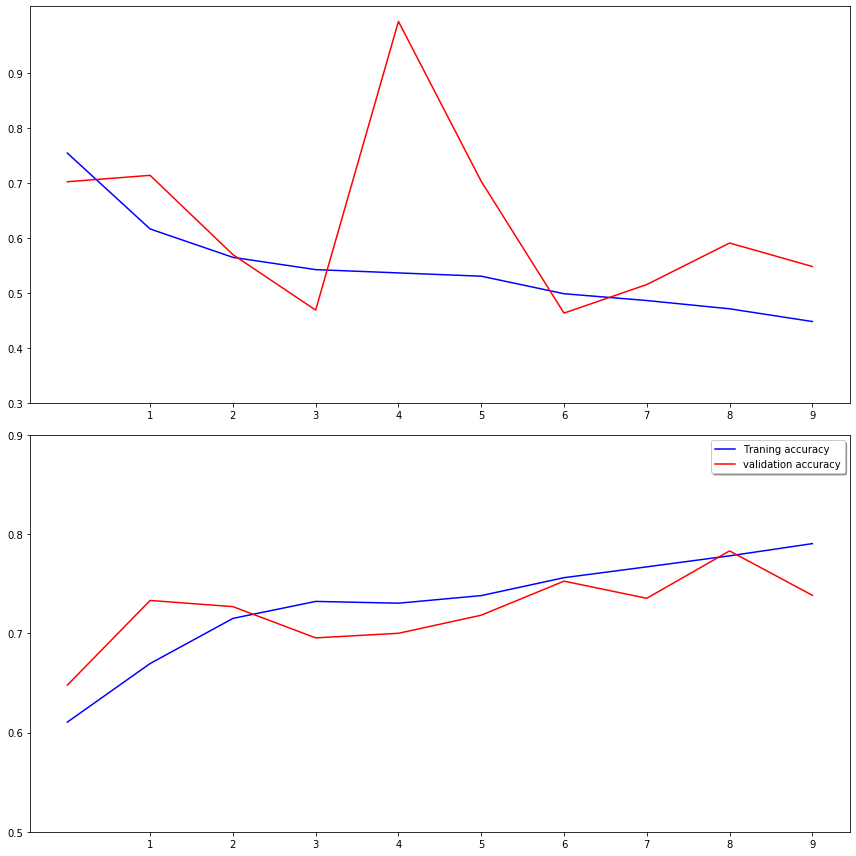

In [29]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label='Training loss')
ax1.plot(history.history['val_loss'], color='r', label='validation loss')
legend = plt.legend(loc='best', shadow=True)
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0.3, 1, 0.1))


ax2.plot(history.history['accuracy'], color='b', label='Traning accuracy')
ax2.plot(history.history['val_accuracy'], color='r', label="validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_yticks(np.arange(0.5, 1, 0.1))
legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()